In [2]:
import glob
import numpy as np
import os
import os.path as path
import imageio
from scipy import misc
from keras.models import Sequential, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer, Reshape
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# IMAGE_PATH should be the path to the planesnet folder
file_paths = glob.glob(path.join(os.getenv("HOME"),'work/airplane_cnn/planesnet', '*.png'))

In [4]:
# Load the images
images = [imageio.imread(i_path) for i_path in file_paths]
images = np.asarray(images)

In [5]:
images.shape

(32000, 20, 20, 3)

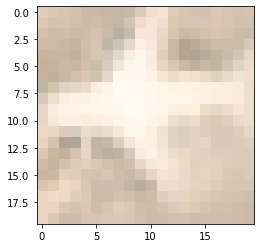

In [21]:
plt.imshow(images[30402]);

In [27]:
# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])

In [28]:
image_size

array([20, 20,  3])

In [30]:
images = images / 255

In [32]:
n_images = images.shape[0]
labels = np.zeros(n_images)

In [33]:
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [35]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.9

In [36]:
# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

In [37]:
# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]

In [22]:
## MODEL CREATION ##

N_LAYERS = 3

# Define model hyperparamters
MIN_NEURONS = 20
MAX_NEURONS = 150
KERNEL = (3, 3)

# Determine the # of neurons in each convolutional layer
steps = np.floor(MAX_NEURONS / (N_LAYERS + 1))
nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
nuerons = nuerons.astype(np.int32)

In [23]:
steps

37.0

In [24]:
nuerons

array([ 20,  57,  94, 131], dtype=int32)

In [67]:
# Define a model
model = Sequential()
# Add convolutional layers
for i in range(0, N_LAYERS):
    if i == 0:
        shape = (image_size[0], image_size[1], image_size[2])
        model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
    else:
        model.add(Conv2D(nuerons[i], KERNEL))

    model.add(Activation('relu'))

In [68]:
# Add max pooling layer with dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(MAX_NEURONS))
model.add(Activation('relu'))

In [69]:
# Add output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [75]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
# Print a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 18, 18, 20)        560       
_________________________________________________________________
activation_11 (Activation)   (None, 18, 18, 20)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 57)        10317     
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 57)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 94)        48316     
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 94)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 94)         

In [88]:
## MODEL TRAINING ##
# Training Hyperparamters
EPOCHS = 9
BATCH_SIZE = 200

# Train the model
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
             validation_data = [x_test, y_test])

Train on 28800 samples, validate on 3200 samples
Epoch 1/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0610 - acc: 0.9771 - val_loss: 0.0518 - val_acc: 0.9806
Epoch 2/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0613 - acc: 0.9772 - val_loss: 0.0540 - val_acc: 0.9809
Epoch 3/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0582 - acc: 0.9788 - val_loss: 0.0658 - val_acc: 0.9794
Epoch 4/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0503 - acc: 0.9819 - val_loss: 0.0513 - val_acc: 0.9822
Epoch 5/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0376 - acc: 0.9874 - val_loss: 0.0485 - val_acc: 0.9822
Epoch 6/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0402 - acc: 0.9855 - val_loss: 0.0633 - val_acc: 0.9747
Epoch 7/9
28800/28800 [==============================] - 59s 2ms/step - loss: 0.0391 - acc: 0.9861 - val_loss: 0.0437 - val_acc: 0.9838

In [89]:
history_dict = history.history

In [90]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

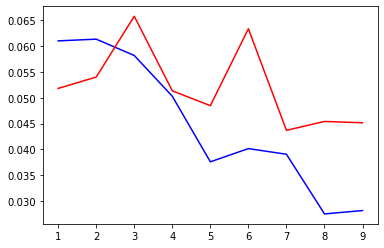

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(1, EPOCHS + 1)

loss_values = history_dict['loss']
acc_values = history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, loss_values, 'b')
# plt.plot(epochs, acc_values, 'b')
plt.plot(epochs, val_loss_values, 'r')
# plt.plot(epochs, val_acc_values, 'r')

In [46]:
## MODEL EVALUATION ##
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

In [47]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.975625
